In [ ]:
# --- Alzheimer MRI Classification with ResNet101 ---

#  1. Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import models
from torchvision.utils import make_grid
import cv2


In [ ]:


#  2. Device Setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:

#  3. Dataset and Dataloader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_dir = "./data"
train_data = ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_data = ImageFolder(os.path.join(data_dir, 'val'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class_names = train_data.classes


In [ ]:


#  4. Load ResNet101 Model
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\molim/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:45<00:00, 3.90MB/s] 


In [ ]:

#  5. Training and Validation
train_acc, val_acc = [], []
train_loss, val_loss = [], []

epochs = 10
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    train_acc.append(acc)
    train_loss.append(running_loss / len(train_loader))

    model.eval()
    correct, total, val_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc.append(100 * correct / total)
    val_loss.append(val_running_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {acc:.2f}% - Val Acc: {val_acc[-1]:.2f}%")



Epoch 1/10 - Train Acc: 88.21% - Val Acc: 98.67%
Epoch 2/10 - Train Acc: 98.03% - Val Acc: 98.75%
Epoch 3/10 - Train Acc: 98.45% - Val Acc: 97.03%
Epoch 4/10 - Train Acc: 99.03% - Val Acc: 99.66%
Epoch 5/10 - Train Acc: 99.08% - Val Acc: 99.48%
Epoch 6/10 - Train Acc: 99.19% - Val Acc: 99.67%
Epoch 7/10 - Train Acc: 99.43% - Val Acc: 98.45%
Epoch 8/10 - Train Acc: 99.29% - Val Acc: 99.66%
Epoch 9/10 - Train Acc: 99.42% - Val Acc: 99.81%
Epoch 10/10 - Train Acc: 99.35% - Val Acc: 99.58%


In [ ]:

#  6. Save the Model
torch.save(model.state_dict(), "resnet101_alzheimers.pth")



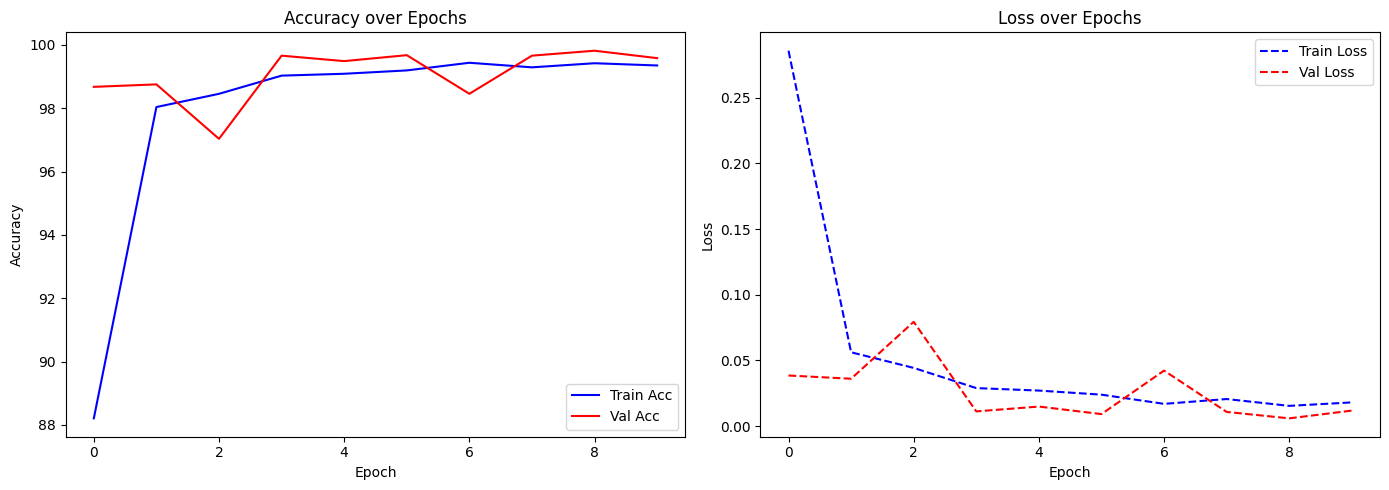

In [ ]:

#  7. Accuracy and Loss Curves
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_acc, 'b-', label='Train Acc')
plt.plot(val_acc, 'r-', label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss, 'b--', label='Train Loss')
plt.plot(val_loss, 'r--', label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()



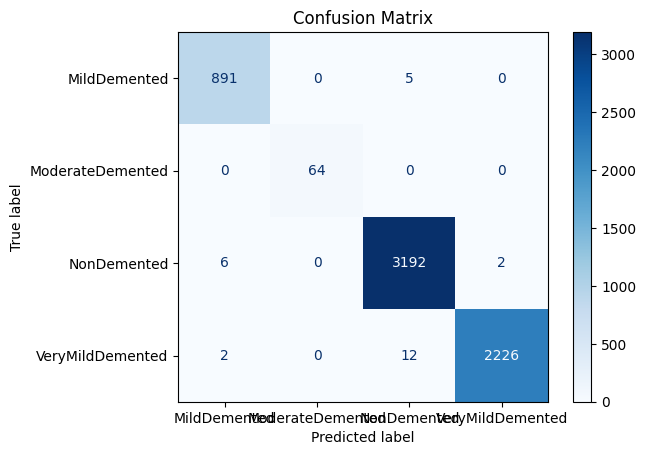

In [ ]:

#  8. Confusion Matrix
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



In [ ]:

#  9. Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def save_gradient(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def save_activation(module, input, output):
            self.activations = output

        target_layer.register_forward_hook(save_activation)
        target_layer.register_backward_hook(save_gradient)

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        self.model.zero_grad()
        output[0, class_idx].backward()

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam -= cam.min()
        cam /= cam.max()
        return cam


c:\Users\molim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


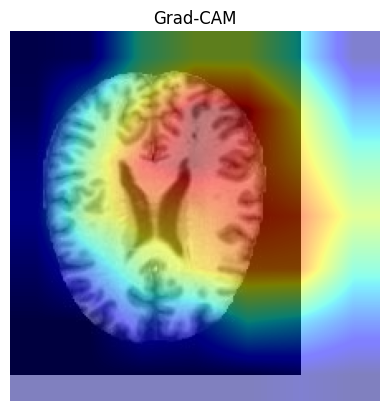

In [ ]:

#  Example for Grad-CAM visualization
from PIL import Image

image_path = "data/val/NonDemented/26 (67).jpg"  # replace with your path
raw_image = Image.open(image_path).convert('RGB')
input_tensor = transform(raw_image).unsqueeze(0).to(device)

# Apply Grad-CAM
target_layer = model.layer4[-1]
gradcam = GradCAM(model, target_layer)
cam = gradcam.generate_cam(input_tensor)

# Overlay
plt.imshow(raw_image)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()
